### Make initial conditions for present day experiment

Based on observations from B-SOSE (http://sose.ucsd.edu/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cmocean
import matplotlib.backends.backend_pdf
import gsw
import sys
# sys.path.append('/users/birgal/')
sys.path.append('/home/birgal/Documents/antarctic/analysis/')
from nemo_python.interpolation import interp_latlon_cf, neighbours, neighbours_z, extend_into_mask

In [4]:
#  File locations on laptop:
folder_SOSE = '/home/birgal/Documents/antarctic/data/B-SOSE/'
folder_BC   = '/home/birgal/Documents/antarctic/analysis/boundary-conditions/observational/'
folder_NEMO = '/home/birgal/Documents/antarctic/data/bathymetry/'

# Load files:
nemo = xr.open_dataset(f'{folder_NEMO}coordinates_AIS.nc').squeeze()
nemo_mask = xr.open_dataset(f'{folder_NEMO}mesh_mask-20231025.nc')
sose      = xr.open_dataset(f'{folder_SOSE}SALT_climatology_m01.nc')
domcfg    = xr.open_dataset(f'{folder_NEMO}domain_cfg-20231025.nc')

nemo_depths = nemo_mask.nav_lev.values

#### Functions

In [114]:
dataset = 'SOSE'
# dl = 0 # depth level
datasets = []

for dl in [20,30,40]:
    if dataset == 'SOSE':
        name_remapping = {'XC':'lon', 'YC':'lat', 'Z':'depth'}
            
        # Read temperature and salinity from January as a single dataset, and slice to latitude range that I want to interpolate to reduce size
        SOSE_salt = xr.open_dataset(f'/home/birgal/Documents/antarctic/data/B-SOSE/SALT_climatology_m01.nc').rename(name_remapping).sel(lat=slice(-90, -48))
        SOSE_temp = xr.open_dataset(f'/home/birgal/Documents/antarctic/data/B-SOSE/THETA_climatology_m01.nc').rename(name_remapping).sel(lat=slice(-90, -48))
        
        # For SOSE, convert longitudes from 0-360 to -180 to 180 
        SOSE_temp['lon'] = xr.where(SOSE_temp.lon  > 180, SOSE_temp.lon - 360, SOSE_temp.lon)
        SOSE_salt['lon'] = xr.where(SOSE_salt.lon  > 180, SOSE_salt.lon - 360, SOSE_salt.lon)
        SOSE_temp = SOSE_temp.sortby('lon'); SOSE_salt = SOSE_salt.sortby('lon')
            
        # Convert to TEOS10
        # Need pressure in dbar at every 3D point: approx depth in m
        SOSE_press = np.abs(xr.broadcast(SOSE_temp['depth'], SOSE_temp['THETA'])[0])
        # Also need 3D lat and lon
        SOSE_lon = xr.broadcast(SOSE_temp['lon'], SOSE_temp['THETA'])[0]
        SOSE_lat = xr.broadcast(SOSE_temp['lat'], SOSE_temp['THETA'])[0]
        # Get absolute salinity
        SOSE_SA  = gsw.SA_from_SP(SOSE_salt['SALT'], SOSE_press, SOSE_lon, SOSE_lat)
        # Get conservative temperature
        SOSE_CT  = gsw.CT_from_t(SOSE_SA, SOSE_temp['THETA'], SOSE_press)
        # Now wrap up into a new Dataset
        source = xr.Dataset({'lon':SOSE_temp['lon'], 'lat':SOSE_temp['lat'], 
                             'THETA': xr.where(SOSE_temp.maskC.isel(depth=dl)==1, SOSE_CT.isel(depth=dl), np.nan)}) #, 'THETA':SOSE_CT.isel(depth=0), 'salt':SOSE_SA.isel(depth=0)})
        
        # Interpolate horizontally
        interp_src = interpolate_IC(source, nemo)
        
        datasets.append(interp_src)

SOSE_interpolated = xr.concat(datasets, dim='Z')

In [86]:
# source_mask = (sose.maskC == 0)
# nemo_ocn    = (nemo_mask.tmask.isel(time_counter=0, nav_lev=0) != 0)

# # in ocean cells that have NaN value, fill with 1 for now
# # xr.where(nemo_ocn and interp_src.THETA == 0, )
# mask_to_fill = xr.where(np.isnan(interp_src.THETA.values)*nemo_ocn, 1, 0) # regions that will need to be filled
# # could use numpy masked edges in subsequent loops to fill
# (mask_to_fill==1)
# for each value in the mask, select the 9 closest points from the interpolated theta and take the average of those and fill the value

In [115]:
nemo_ocn           = (nemo_mask.tmask.isel(time_counter=0, nav_lev=[20,30,40]) != 0)
interp_src_tofill  = xr.where(np.isnan(SOSE_interpolated.THETA.values)*nemo_ocn, 1000, SOSE_interpolated.THETA.values)

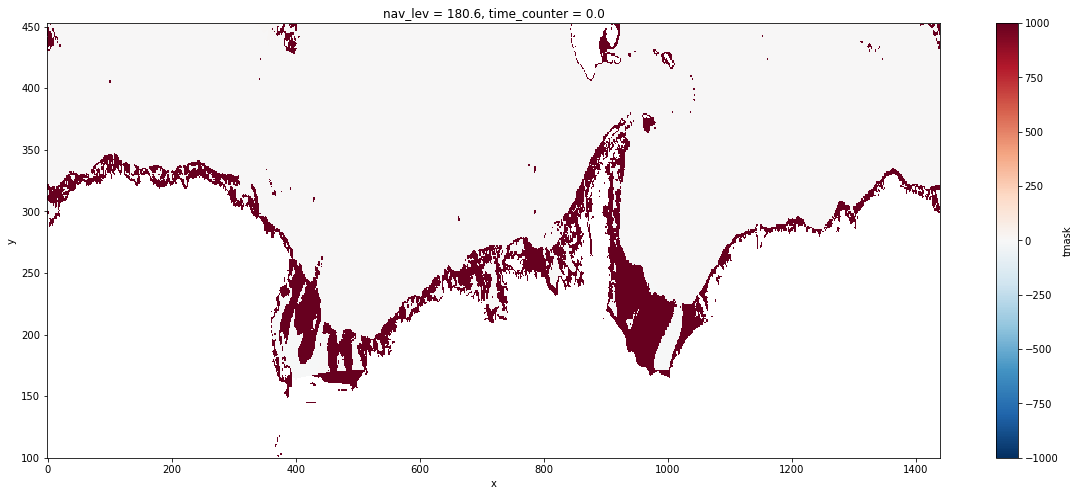

In [119]:
interp_src_tofill.isel(nav_lev=1).plot(ylim=(100,453), figsize=(20,8))

In [120]:
theta_extended     = extend_into_mask(interp_src_tofill.values, missing_val=1000)

for iter in range(0,100):
    theta_extended = extend_into_mask(theta_extended, missing_val=1000) # doesn't change any of the values

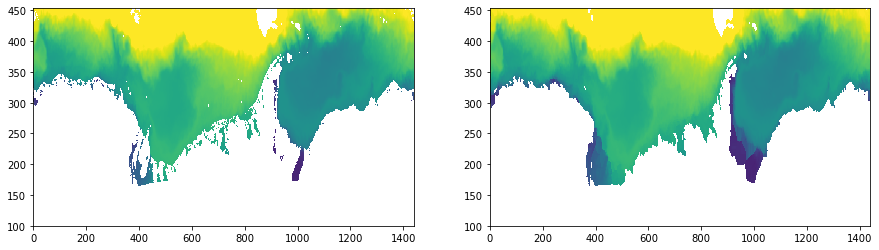

In [123]:
int=1
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].pcolormesh(SOSE_interpolated.THETA.isel(Z=int).values, vmin=-2, vmax=3)
ax[1].pcolormesh(theta_extended[int,:,:], vmin=-2, vmax=3)
# theta_plot = np.ma.masked_where(~np.isnan(interp_src.THETA.values)*nemo_ocn, theta_extended)
# ax[1].pcolormesh(theta_plot, vmin=-1, vmax=1)
# ax[1].pcolormesh(interp_src_tofill, vmin=-2, vmax=3)

for axis in ax.ravel():
    axis.set_ylim(100,453)

In [6]:
def interpolate_IC(source, nemo):
    # Steps:
    # - interpolate source file to nemo grid for each horizontal slice over all depth levels 
    # - fill areas in cavities with nearest neighbour

    # Interpolate slices of depth levels along lat-lon
    data_interp = interp_latlon_cf(source, nemo, pster_src=False, periodic_src=True, periodic_nemo=True, method='conservative')

    # source_data = discard_and_fill(source, source_mask[0,:], fill[0,:], use_3d=False, missing_val=missing_val)
    
    return data_interp

In [7]:
# # Given an array with missing values, extend the data into the mask by setting missing values to the average of their non-missing neighbours, and repeating as many times as the user wants.
# # If "data" is a regular array with specific missing values, set missing_val (default -9999). If "data" is a MaskedArray, set masked=True instead.
# # Setting use_3d=True indicates this is a 3D array, and where there are no valid neighbours on the 2D plane, neighbours above and below should be used.
# # Setting preference='vertical' (instead of default 'horizontal') indicates that if use_3d=True, vertical neighbours should be preferenced over horizontal ones.
# # Setting use_1d=True indicates this is a 1D array.
# def extend_into_mask (data, missing_val=-9999, masked=False, use_1d=False, use_3d=False, preference='horizontal', num_iters=1):

#     if missing_val != -9999 and masked:
#         print("Error (extend_into_mask): can't set a missing value for a masked array")
#         sys.exit()
#     if use_1d and use_3d:
#         print("Error (extend_into_mask): can't have use_1d and use_3d at the same time")
#         sys.exit()
#     if use_3d and preference not in ['horizontal', 'vertical']:
#         print('Error (extend_into_mask): invalid preference ' + preference)

#     if masked:
#         # MaskedArrays will mess up the extending
#         # Unmask the array and fill the mask with missing values
#         data_unmasked = data.data
#         data_unmasked[data.mask] = missing_val
#         data = data_unmasked

#     for iter in range(num_iters):
#         # Find the neighbours of each point, whether or not they are missing, and how many non-missing neighbours there are.
#         # Then choose the points that can be filled.
#         # Then set them to the average of their non-missing neighbours.
#         if use_1d:
#             # Just consider horizontal neighbours in one direction
#             data_w, data_e, valid_w, valid_e, num_valid_neighbours = neighbours(data, missing_val=missing_val, use_1d=True)
#             index = (data == missing_val)*(num_valid_neighbours > 0)
#             data[index] = (data_w[index]*valid_w[index] + data_e[index]*valid_e[index])/num_valid_neighbours[index]
#         elif use_3d and preference == 'vertical':
#             # Consider vertical neighbours
#             data_d, data_u, valid_d, valid_u, num_valid_neighbours = neighbours_z(data, missing_val=missing_val)
#             index = (data == missing_val)*(num_valid_neighbours > 0)
#             data[index] = (data_u[index]*valid_u[index] + data_d[index]*valid_d[index])/num_valid_neighbours[index]
#         else:
#             # Consider horizontal neighbours in both directions
#             data_w, data_e, data_s, data_n, valid_w, valid_e, valid_s, valid_n, num_valid_neighbours = neighbours(data, missing_val=missing_val)
#             index = (data == missing_val)*(num_valid_neighbours > 0)
#             data[index] = (data_w[index]*valid_w[index] + data_e[index]*valid_e[index] + data_s[index]*valid_s[index] + data_n[index]*valid_n[index])/num_valid_neighbours[index]
#         if use_3d:
#             # Consider the other dimension(s). Find the points that haven't already been filled based on the first dimension(s) we checked, but could be filled now.
#             if preference == 'vertical':
#                 # Look for horizontal neighbours
#                 data_w, data_e, data_s, data_n, valid_w, valid_e, valid_s, valid_n, num_valid_neighbours_new = neighbours(data, missing_val=missing_val)
#                 index = (data == missing_val)*(num_valid_neighbours == 0)*(num_valid_neighbours_new > 0)
#                 data[index] = (data_w[index]*valid_w[index] + data_e[index]*valid_e[index] + data_s[index]*valid_s[index] + data_n[index]*valid_n[index])/num_valid_neighbours_new[index]
#             elif preference == 'horizontal':
#                 # Look for vertical neighbours
#                 data_d, data_u, valid_d, valid_u, num_valid_neighbours_new = neighbours_z(data, missing_val=missing_val)
#                 index = (data == missing_val)*(num_valid_neighbours == 0)*(num_valid_neighbours_new > 0)
#                 data[index] = (data_u[index]*valid_u[index] + data_d[index]*valid_d[index])/num_valid_neighbours_new[index]
                
#     if masked:
#         # Remask the MaskedArray
#         data = ma.masked_where(data==missing_val, data)

#     return data    

In [8]:
# # Finds the value of the given array to the west, east, south, north of every point, as well as which neighbours are non-missing, and how many neighbours are non-missing.
# # Can also do 1D arrays (so just neighbours to the left and right) if you pass use_1d=True.
# def neighbours (data, missing_val=-9999, use_1d=False):

#     # Find the value to the west, east, south, north of every point
#     # Just copy the boundaries
#     data_w          = np.empty(data.shape)
#     data_w[...,1:]  = data[...,:-1]
#     data_w[...,0]   = data[...,0]
#     data_e          = np.empty(data.shape)
#     data_e[...,:-1] = data[...,1:]
#     data_e[...,-1]  = data[...,-1]
#     if not use_1d:
#         data_s            = np.empty(data.shape)
#         data_s[...,1:,:]  = data[...,:-1,:]
#         data_s[...,0,:]   = data[...,0,:]
#         data_n            = np.empty(data.shape)
#         data_n[...,:-1,:] = data[...,1:,:]
#         data_n[...,-1,:]  = data[...,-1,:]     
        
#     # Arrays of 1s and 0s indicating whether these neighbours are non-missing
#     valid_w = (data_w != missing_val).astype(float)
#     valid_e = (data_e != missing_val).astype(float)
#     if use_1d:
#         # Number of valid neighoburs of each point
#         num_valid_neighbours = valid_w + valid_e
#         # Finished
#         return data_w, data_e, valid_w, valid_e, num_valid_neighbours
        
#     valid_s = (data_s != missing_val).astype(float)
#     valid_n = (data_n != missing_val).astype(float)
    
#     num_valid_neighbours = valid_w + valid_e + valid_s + valid_n
    
#     return data_w, data_e, data_s, data_n, valid_w, valid_e, valid_s, valid_n, num_valid_neighbours


# # Like the neighbours function, but in the vertical dimension: neighbours above and below
# def neighbours_z (data, missing_val=-9999):

#     data_u              = np.empty(data.shape)
#     data_u[...,1:,:,:]  = data[...,:-1,:,:]
#     data_u[...,0,:,:]   = data[...,0,:,:]
    
#     data_d              = np.empty(data.shape)
#     data_d[...,:-1,:,:] = data[...,1:,:,:]
#     data_d[...,-1,:,:]  = data[...,-1,:,:]
#     valid_u = (data_u  != missing_val).astype(float)
#     valid_d = (data_d  != missing_val).astype(float)
    
#     num_valid_neighbours_z = valid_u + valid_d
    
#     return data_u, data_d, valid_u, valid_d, num_valid_neighbours_z